# Finding Hidden States

To start the analysis of burst data with H<sup>2</sup>MM, we first need to process the data with FRETBursts, one of the dependencies of burstH2MM.

> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First let's import the necessary modules:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as hmm

sns = frb.init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


and load the data and search for bursts:

In [2]:
filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)

Now it is best to check the alternation period etc.:

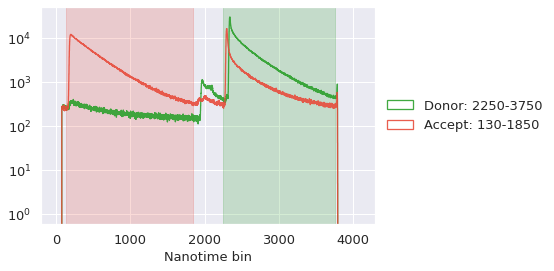

In [3]:
# plot the alternation histogram
frb.bpl.plot_alternation_hist(frbdata)

If the alternation period looks good, we can apply the alternation period to assign Donor/Acceptor excitation to each photon:

In [4]:
# if the alternation period is correct, apply data
frb.loader.alex_apply_period(frbdata)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



Then calculate the background rates used to set thresholds for finding bursts:

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]


<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Inter-photon delays (ms)', ylabel='# Delays'>

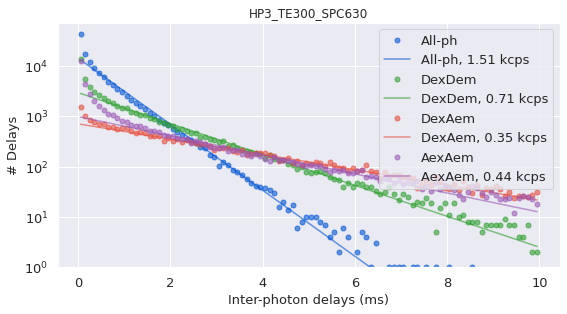

In [5]:
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
frb.dplot(frbdata, frb.hist_bg)

And finally search for bursts and refine the selection by appropriate burst size/width/other parameters:

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
<class 'matplotlib.figure.Figure'>


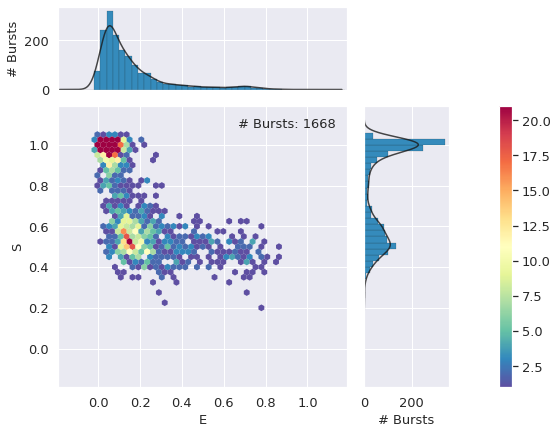

In [6]:
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)

frb.alex_jointplot(frbdata_sel);

Now that the data is selected, we can segment the photons into bursts, which will be stored in a BurstData object:

In [7]:
bdata = hmm.BurstData(frbdata_sel)

`bdata` is now the object that will organize the downstream information for optimization. When `bdata` was created, it automatically also generated a `H2MM_list` object, stored in `BurstData.models` which is where we can perform the H2MM optimizations.

So let’s run a round of optimizations:

In [8]:
# calculate models
bdata.models.calc_models()

The model converged after 2 iterations

The model converged after 35 iterations

The model converged after 125 iterations

The model converged after 404 iterations

2

When you run this, it will optimize H<sup>2</sup>MM models over a range of states. The next task is to select the ideal number of states. To select this, there are several options, but for now we will use the Integrated Complete Likelihood (ICL). The model with the minimal ICL is usually the best model:

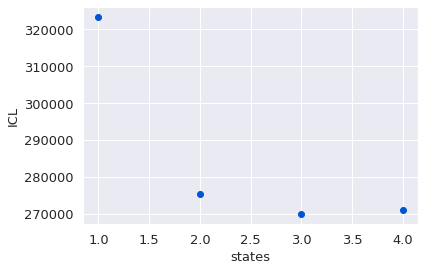

In [9]:
hmm.ICL_plot(bdata.models)

Now that the ideal model has been identified, we can plot the E/S values of each dwell with `dwell_ES_scatter()`, which colored by state. We can also overlay the E/S values derived from the `H2MM model` over the dwell values. 

> Note that we pass the `s=50, c="r"` arguments to the `scatter_ES()` function, which ensure the size of the points is appropriate, as well as making the color pop

> There are many more plotting functions. You can review these in the [Plotting](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#plotting) module.

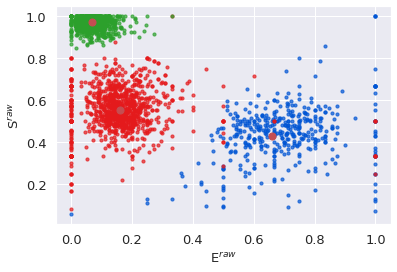

In [10]:
# plot the dwell ES of the result
hmm.dwell_ES_scatter(bdata.models[2])
# overlay with the main values,
hmm.scatter_ES(bdata.models[2], s=50, c="r")

It is also important to examine the transtion rate matrix:

In [11]:
bdata.models[2].trans

array([[1.99994147e+07, 5.31727501e+02, 5.35447346e+01],
       [2.05278858e+02, 1.99996914e+07, 1.03279407e+02],
       [7.90895335e+00, 1.16271377e+02, 1.99998758e+07]])

burstH2MM attempts to calculate the most common dwell parameters, and to allow for intelligent selection of different sorts of dwells/bursts and do most of the heavy lifting for the user. These are nearly all stored as attributes in `H2MM_result` objects.

# Divisor Approach

burstH2MM also allows the H2MM input data to incorporate photon nanotimes using the divisor approach. Before using divisors, and therefore nanotimes, it is best to analyze the lifetime decays, and set appropriate thresholds for the IRF of each stream, so we will first plot the decays.

> **Note**
> 
> We are applying these nanotime settings to `bdata`, the original `BurstData` object created at the beginning of the tutorial. This is because these are universal settings for all `H2MM_list` objects created from their parent `BurstData` object. 
> As such, these settings are “remembered” through all children of bdata.

([[<matplotlib.lines.Line2D at 0x7facbe07b5e0>],
 <matplotlib.legend.Legend at 0x7facbe05e460>)

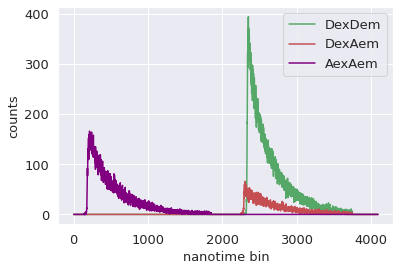

In [12]:
hmm.raw_nanotime_hist(bdata)

Now we can choose the best thresholds for the IRF, and we will set the BurstData.irf_thresh attribute.

> **Note**
> 
> The order of thresholds corresponds to the order of streams in `BurstData.ph_strearms` is the order of threshold in `BurstData.irf_thresh`

In [13]:
bdata.irf_thresh = np.array([2355, 2305, 220])

Now that the IRF thresholds have been set, we should have no problems down the road when calculating dwell mean nanotimes and other such parameters.

We are now ready to actually start using the divisor approach. First a new divisor must be set:

In [14]:
div_name = bdata.auto_div(1)

This creates a new divisor based `H2MM_list` object stored in the dictionary `BurstData.div_models` with the key returned by the function (stored in `div_name`). So let’s extract the `H2MM_list` object generated, and then run an optimization:

In [15]:
# run H2MM analysis
bdata.div_models[div_name].calc_models()

The model converged after 3 iterations

The model converged after 27 iterations

The model converged after 82 iterations

The model converged after 402 iterations

2

Next, as before, we need to look at the ICL, to choose the ideal model

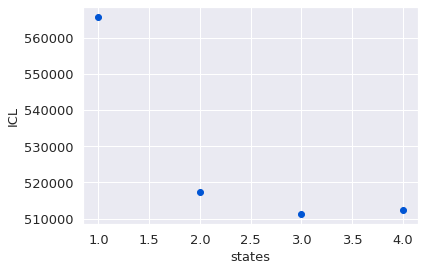

In [16]:
hmm.ICL_plot(bdata.div_models[div_name])

The 3 state model again looks like the best fit, so we will reference it with index 2 (remember python indexes from 0). 
Now we can finally plot the distribution of nanotimes per state. For this there is the `dwell_tau_hist()`

[[<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>]]

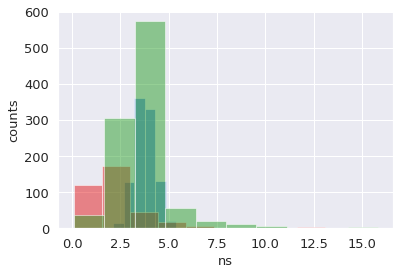

In [17]:
hmm.dwell_tau_hist(bdata.div_models[div_name][2])